<a href="https://colab.research.google.com/github/as9786/ParrotnlpJeju/blob/main/toxic1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 21/03/28

1. 3/31 : 데이터전처리(토큰화,불용어 제거,Word2vec,glove, 정규표현식, pandas profiling 등) 
  

# 모듈 가져오기


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout, Flatten
#Bidirectional은 양방향으로 데이터를 보기 위해서 사용되는 함수
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

#from keras_contrib.layers import CRF
#from keras_contrib.losses import crf_loss
#from keras_contrib.metrics import crf_viterbi_accuracy

# 데이터 불러오기

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/train.csv')
test = pd.read_csv('/content/drive/MyDrive/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/sub1.csv')

In [ ]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
train.tail(100)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159471,fe5b78a6d22198c4,If some people are anti-catholic then their ju...,0,0,0,0,0,0
159472,fe6585aaa6182d28,You ignored him too,0,0,0,0,0,0
159473,fe77e59403ac395e,", as User:Dr.K wasn't saying it in the article",0,0,0,0,0,0
159474,fe7b1f2bd3756b0b,"LaserActive \n\nHi SchuminWeb, I am confused b...",0,0,0,0,0,0
159475,fe93b5e609f5cfdd,Lists of Islamic Jihads,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [ ]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
train.loc[0,'comment_text']

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [ ]:
train.shape

(159571, 8)

In [ ]:
#데이터 체크
train_length = train.comment_text.apply(len)
train_length.head()

0    264
1    112
2    233
3    622
4     67
Name: comment_text, dtype: int64

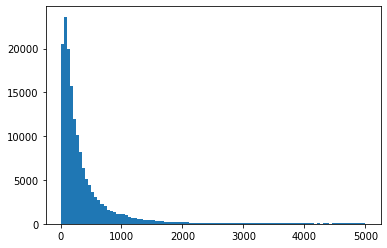

In [ ]:
#그래프
plt.hist(train_length,bins=100)
plt.show()

Zipf의 법칙이 적용 되는 것을 확인할 수 있음.

Zipf의 법칙 : 텍스트에 불규칙하게 분포되어 보이는 어휘(타입)들을 빈도 내림차순으로 나열할 때 분포적 규칙성 제시

# EDA

In [ ]:
print("length max : ",np.max(train_length))
print("length min : ", np.min(train_length))
print("mean length : ",np.mean(train_length))
print("Q1 : ",np.percentile(train_length,75))
print("std length : ",np.std(train_length))

length max :  5000
length min :  6
mean length :  394.0732213246768
Q1 :  435.0
std length :  590.7184309382149


In [ ]:
#결측값 체크
print("Train NaN : ",train.comment_text.isna().sum())
print("Test NaN : ",test.comment_text.isna().sum())

Train NaN :  0
Test NaN :  0


In [ ]:
#데이터 나누기(X 값에는 feature y 값에는 label 넣어주기)
X = train.comment_text
y = train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values
test = test.comment_text

In [ ]:
X[:5]

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [ ]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

# Tokenizer

In [ ]:
num_words = 20000
max_len = 150
emb_size = 128

In [ ]:
tok = Tokenizer(num_words=num_words)
tok.fit_on_texts(list(X)) # fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성한다.

In [ ]:
X = tok.texts_to_sequences(X)
test = tok.texts_to_sequences(test)

In [ ]:
# 데이터 빈도 수
word_index = tok.word_index
word_index

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20,
 'with': 21,
 'if': 22,
 'article': 23,
 'was': 24,
 'or': 25,
 'but': 26,
 'page': 27,
 'wikipedia': 28,
 'my': 29,
 'an': 30,
 'from': 31,
 'by': 32,
 'do': 33,
 'at': 34,
 'me': 35,
 'about': 36,
 'so': 37,
 'talk': 38,
 'what': 39,
 'can': 40,
 'there': 41,
 'all': 42,
 'has': 43,
 'will': 44,
 'please': 45,
 'no': 46,
 'would': 47,
 'one': 48,
 'like': 49,
 'just': 50,
 'they': 51,
 'he': 52,
 'which': 53,
 'any': 54,
 'been': 55,
 'should': 56,
 'more': 57,
 'we': 58,
 "don't": 59,
 'some': 60,
 'other': 61,
 'who': 62,
 'here': 63,
 'see': 64,
 'also': 65,
 'his': 66,
 'think': 67,
 'because': 68,
 'know': 69,
 'how': 70,
 'edit': 71,
 'am': 72,
 "i'm": 73,
 'people': 74,
 'why': 75,
 'up': 76,
 'only': 77,
 "it's": 78,
 'out': 79,
 'articles': 80,
 'use': 81,

In [ ]:
#데이터 길이 맞춰줌
X = sequence.pad_sequences(X,maxlen=max_len)
X_test = sequence.pad_sequences(test,maxlen=max_len)

In [ ]:
X[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,   52, 2635,   13,  555, 3809,   73, 4556, 2706,   21,   94,
         38,  803, 2679,  992,  589, 8377,  182], d

# 모델 설계

In [ ]:
input = Input(shape = (max_len,))
layer = Embedding(num_words,emb_size)(input) #num_words의 단어를 emb_size로 벡터화
layer = Bidirectional(LSTM(50,return_sequences=True,recurrent_dropout=0.15))(layer) #return_sequences : 레이어를 여러 개 쌓아 올릴 때
# recurrent_dropout : 현재 Input에 영향을 받는 Parameter에만 Dropout을 적용하는 것
layer = GlobalMaxPool1D()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(50,activation = 'relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(6,activation = 'sigmoid')(layer)
model = Model(inputs = input, outputs=layer)
model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 128)          2560000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 100)          71600     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0   

In [ ]:
file_path = '{epoch:02d}-{val_loss:.5f}.h5'
checkpoint = ModelCheckpoint(file_path,monitor='val_loss',verbose = 1, save_best_only=True)
early_stop = EarlyStopping(monitor='val_loss',patience=1)

In [ ]:
hist = model.fit(X,y,batch_size=32, epochs=2, validation_split = 0.2, callbacks= [checkpoint,early_stop])

Epoch 1/2
3990/3990 [==============================] - 3271s 819ms/step - loss: 0.1063 - accuracy: 0.7898 - val_loss: 0.0492 - val_accuracy: 0.9941

Epoch 00001: val_loss improved from inf to 0.04923, saving model to 01-0.04923.h5
Epoch 2/2
3990/3990 [==============================] - 3181s 797ms/step - loss: 0.0464 - accuracy: 0.9869 - val_loss: 0.0479 - val_accuracy: 0.9937

Epoch 00002: val_loss improved from 0.04923 to 0.04787, saving model to 02-0.04787.h5


In [ ]:
model.save('toxic1_model1',save_format='tf')

INFO:tensorflow:Assets written to: toxic1_model1/assets


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/test.csv')
test_df = test_df['comment_text']
test_final = tok.texts_to_sequences(test_df)
test_padded =sequence.pad_sequences(test_final, maxlen=150)

In [ ]:
### Prediction for test data
predict = model.predict(test_padded)

In [ ]:
test_id_df = pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
target_cols = np.array(['toxic','severe_toxic','obscene', 'threat','insult', 'identity_hate'])
final_predict_test = pd.concat([pd.DataFrame(predict, columns=target_cols)], 1)
t1 = test_id_df['id']
final_predict_test = pd.concat([t1,final_predict_test],1)
final_precict_test.drop('id',axis='columns')
final_predict_test.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998843,5.065380e-01,0.972915,0.056152,0.869336,0.198033
1,0000247867823ef7,0.000468,5.813213e-07,0.000043,0.000001,0.000025,0.000016
2,00013b17ad220c46,0.001666,5.433198e-06,0.000209,0.000013,0.000138,0.000089
3,00017563c3f7919a,0.001210,8.797104e-07,0.000103,0.000001,0.000078,0.000031
4,00017695ad8997eb,0.004937,1.443868e-05,0.000531,0.000033,0.000482,0.000234


In [ ]:
final_predict_test.to_csv("/content/drive/MyDrive/toxic_sub1.csv", mode='w')